In [2]:
import pyjags
import math
import numpy as np
import random
import pandas as pd
import scipy



import arviz as az
import matplotlib.pyplot as plt

# Chapter 5

In [155]:
import sys

In [156]:
JAGS_NA = -sys.float_info.max*(1-1e-15)

In [113]:
# 5.2
n_years = 25 #number of years
N1 = 30 # initial pop
mean_lambda = 1.02 #mean annual pop growth rate
sigma2_lambda = 0.02 #process (temporal) variation of the growth rate
sigma2_y = 20 # variance of the obs. error

In [114]:
# simulate pop. size under assumption of exponential growth

y = np.zeros(n_years)
N = np.zeros(n_years)
N[0] = N1

lambd = np.random.normal(mean_lambda, math.sqrt(sigma2_lambda), n_years)

for t in range(0, n_years  - 1):
    N[t+1] = N[t] * lambd[t]

for t in range(0, n_years - 1):
    y[t] = np.random.normal(N[t], math.sqrt(sigma2_y), 1)


In [110]:
model_52 = '''
model {

    # priors and constraints
    N.est[1] ~ dunif(0, 500) # prior for initial pop size
    mean.lambda ~ dunif(0, 10) #prior for the mean growth rate
    sigma.proc ~ dunif(0, 10) # prior for sd of state process
    sigma2.proc <- pow(sigma.proc, 2)
    tau.proc <- pow(sigma.proc, -2)
    sigma.obs ~ dunif(0, 100) # prior for sd of observation process
    sigma2.obs <- pow(sigma.obs, 2)
    tau.obs <- pow(sigma.obs, -2)

    # likelihood

    # state process
    for (t in 1:(T-1)){
        lambda[t] ~ dnorm(mean.lambda, tau.proc)
        N.est[t+1] <- N.est[t] * lambda[t]
    }

    #observation process
    for (t in 1:T) {
        y[t] ~ dnorm(N.est[t], tau.obs)
    }
}
'''

In [115]:
model_52_data = {
    "y": y,
    "T": n_years
}

In [162]:
inits = {}

A = np.zeros(25)
A[:] = JAGS_NA
A[0] = np.random.uniform(20, 40, 1)


inits['N.est'] = A
inits['sigma.proc'] = np.random.uniform(0, 5, 1)
inits['mean.lambda'] = np.random.uniform(0.1, 2, 1)
inits['sigma.obs'] = np.random.uniform(0, 10, 1)

# how to set init N.est?

In [163]:
parameters = ['lambda', 'mean.lambda', 'sigma2.obs', 'sigma2.proc', 'N.est']

In [167]:
n_iterations = 25000 # number of iterations
thinning = 3 # thinning
burnin = 10000 #burn-in
n_chains = 3

In [170]:
jags_model_52 = pyjags.Model(
    code = model_52,
    data = model_52_data,
    chains = n_chains, 
    init = inits
)

adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


In [171]:
jags_model_52.sample(burnin, vars=[], thin=thinning)

sampling: iterations 30000 of 30000, elapsed 0:00:03, remaining 0:00:00


{}

In [173]:
jags_samples = jags_model_52.sample(n_iterations, vars=parameters)

sampling: iterations 60729 of 75000, elapsed 0:00:06, remaining 0:00:01
sampling: iterations 75000 of 75000, elapsed 0:00:08, remaining 0:00:00


In [176]:
data_model52 = \
    az.from_pyjags(jags_samples)

az.summary(data_model52)

/Users/melvinwevers/opt/miniconda3/envs/vocapture/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (52) in plot_posterior, generating only 40 plots
  warnings.warn(


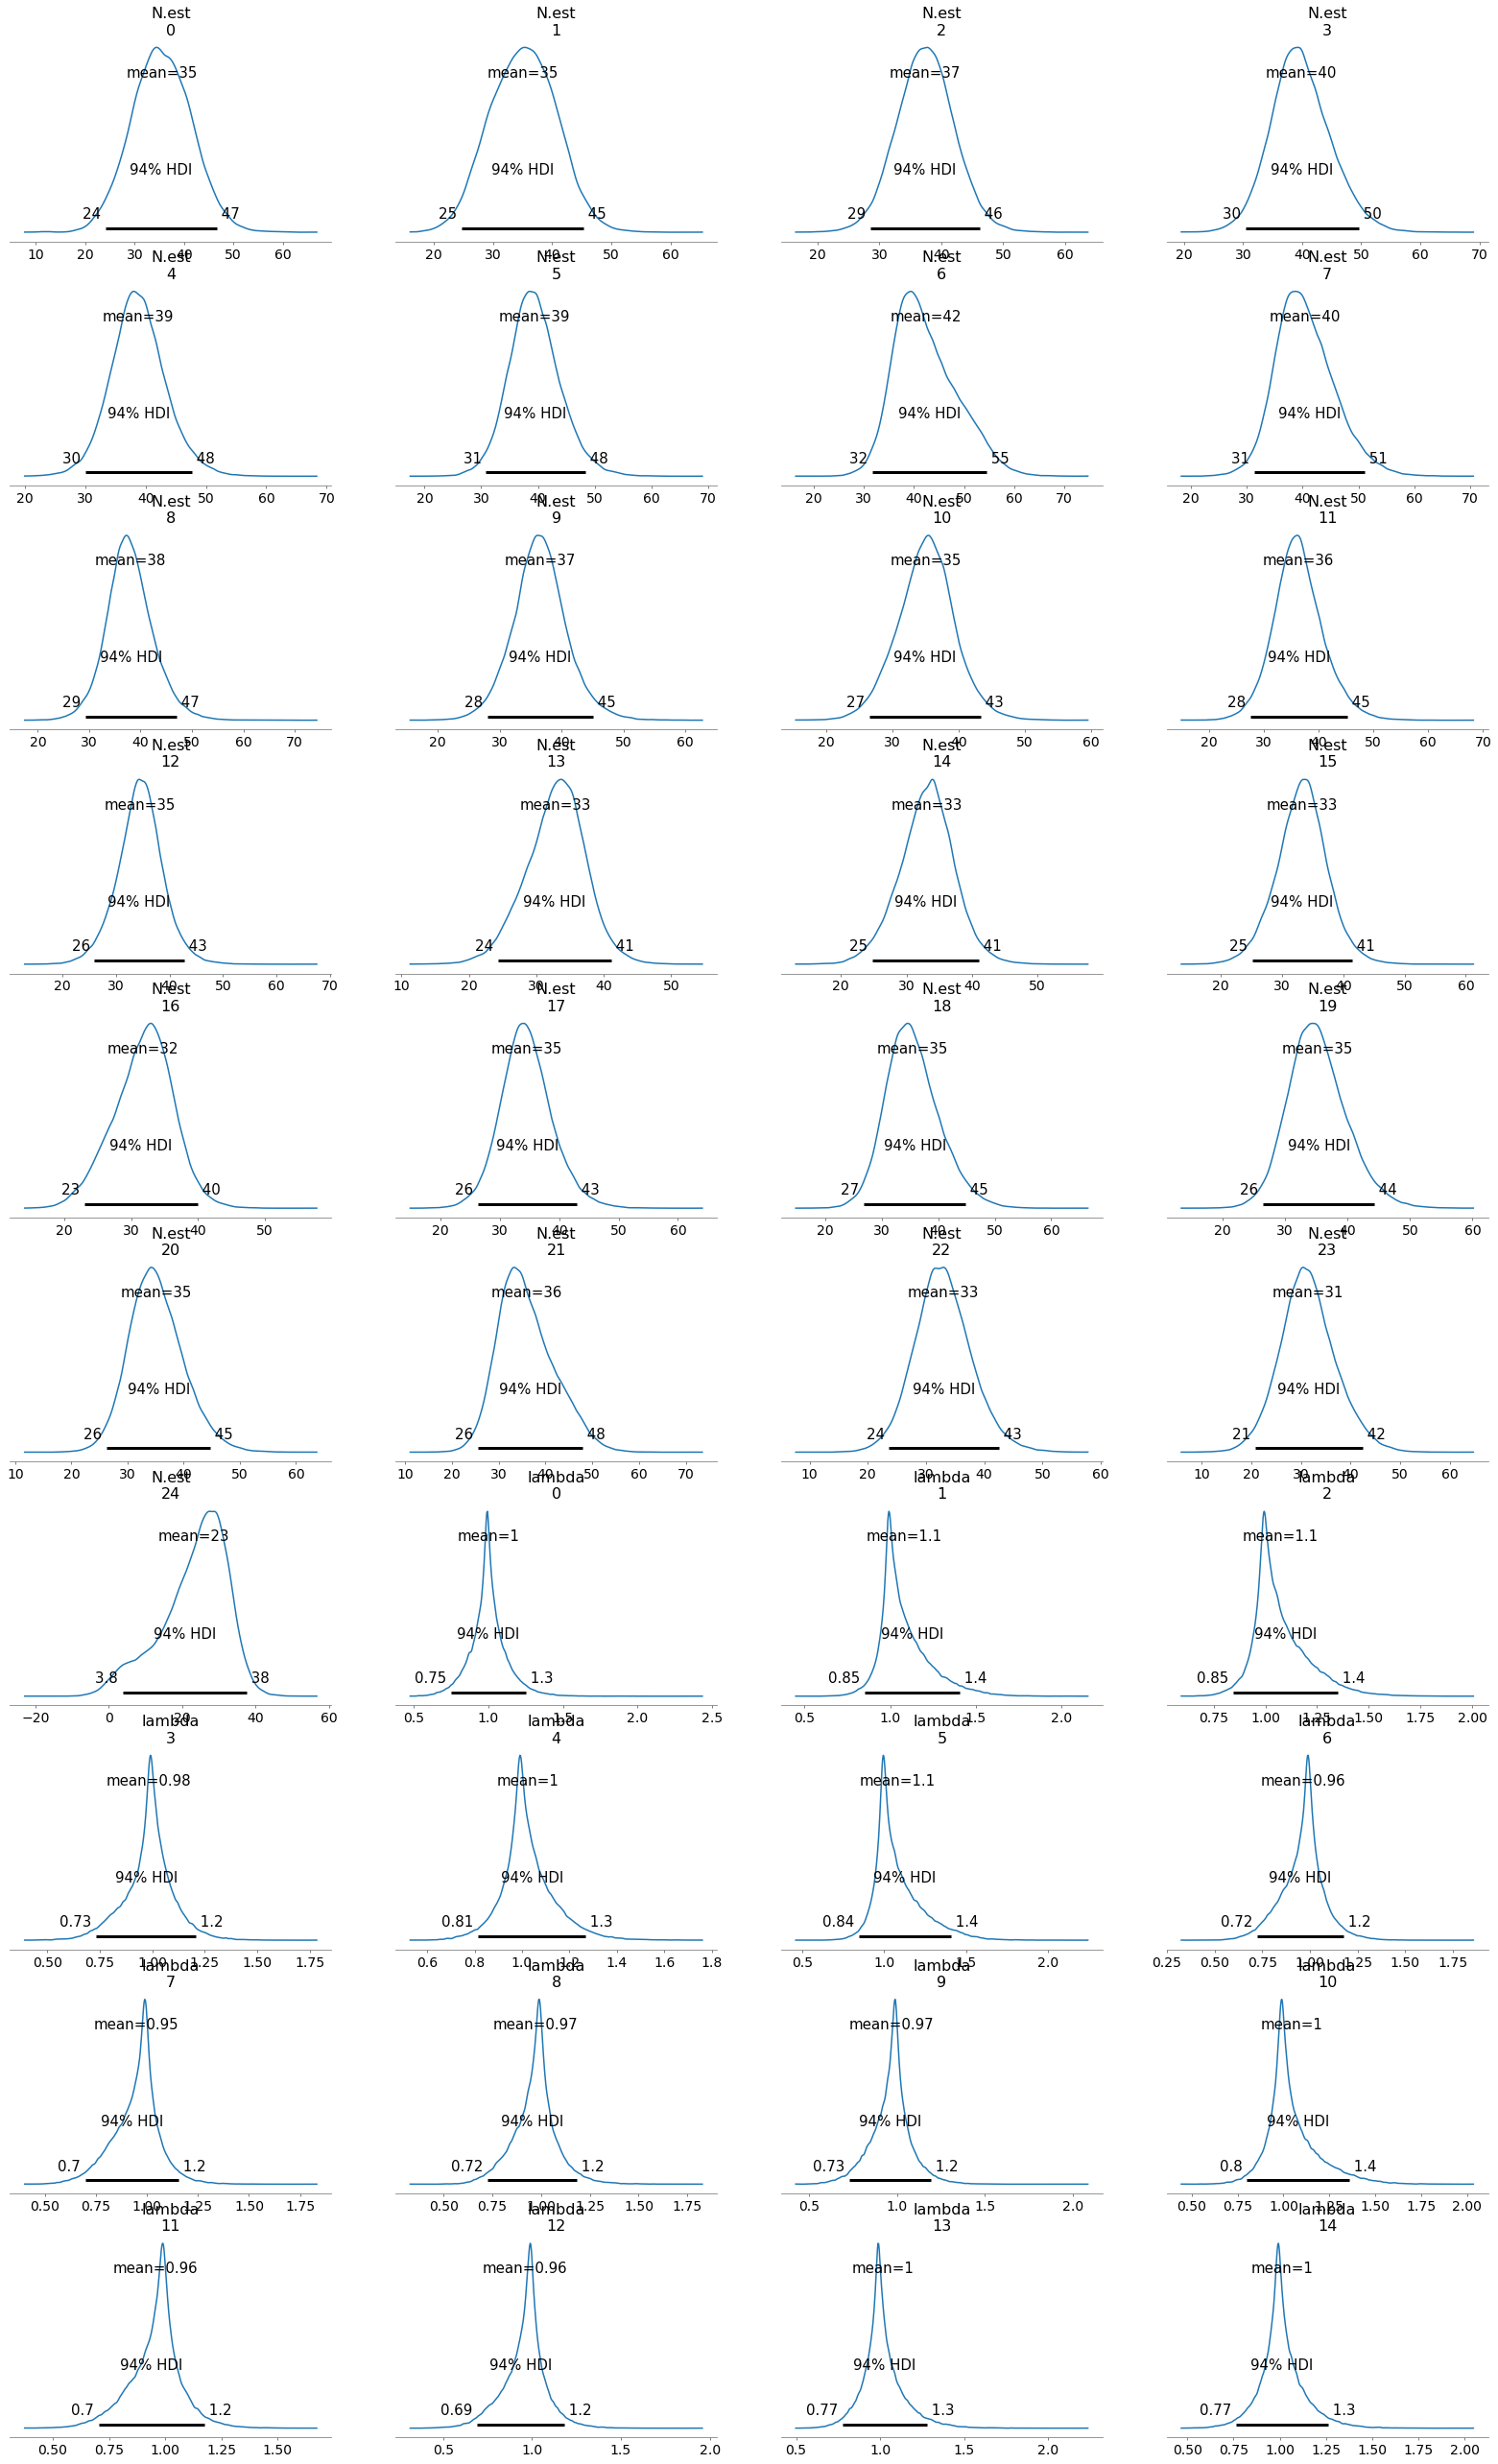

In [178]:
az.plot_posterior(data_model52);

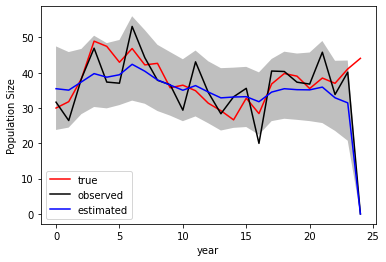

In [187]:
fitted, lower, upper = np.zeros(25), np.zeros(25), np.zeros(25)
for i in range(0, (n_years - 1)):
    fitted[i] = np.mean(jags_samples['N.est'][i])
    lower[i] = np.quantile(jags_samples['N.est'][i], 0.025)
    upper[i] = np.quantile(jags_samples['N.est'][i], 0.975)

plt.plot(range(0, n_years), N, color='red', label='true')
plt.plot(range(0, n_years), y, color='black', label='observed')
plt.plot(range(0, n_years), fitted, color='blue', label='estimated')
plt.ylabel('Population Size')
plt.xlabel('year')
plt.fill_between(range(0, n_years), lower, upper, facecolor='grey', alpha=.5)
plt.legend()

# 5.3 Systematic Bias in the Obs. Process

In [188]:
n_years = 25
N = np.repeat(50, n_years)

p = 0.7
y = np.zeros(25)

for t in range(0, n_years):
    y[t] = np.random.binomial(N[t], p, 1)


In [189]:
jags_data = {
    "y": y,
    "T": n_years
}

In [193]:
inits = {}

A = np.zeros(25)
A[:] = JAGS_NA
A[0] = np.random.uniform(30, 60, 1)


inits['N.est'] = A
inits['sigma.proc'] = np.random.uniform(0, 5, 1)
inits['mean.lambda'] = np.random.uniform(0.1, 2, 1)
inits['sigma.obs'] = np.random.uniform(0, 10, 1)


In [194]:
parameters = ['lambda', 'mean.lambda', 'sigma2.obs', 'sigma2.proc', 'N.est']

In [ ]:
n_iterations = 25000 # number of iterations
thinning = 3 # thinning
burnin = 10000 #burn-in
n_chains = 3

In [195]:
model_53 = pyjags.Model(
    code = model_52,
    data = jags_data,
    chains = 3, 
    init = inits
)


adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


In [197]:
model_53.sample(burnin, vars=[], thin=thinning)

sampling: iterations 30000 of 30000, elapsed 0:00:05, remaining 0:00:00


{}

In [198]:
model_53_samples = model_53.sample(25000, vars=parameters)

sampling: iterations 59460 of 75000, elapsed 0:00:05, remaining 0:00:01
sampling: iterations 75000 of 75000, elapsed 0:00:06, remaining 0:00:00


In [199]:
data_model53 = \
    az.from_pyjags(model_53_samples)

In [201]:
az.summary(data_model53)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
N.est[0],35.874,1.310,33.618,38.507,0.075,0.054,344.0,3454.0,1.02
N.est[1],36.826,1.252,34.384,38.898,0.166,0.118,61.0,5320.0,1.04
N.est[2],36.347,1.082,34.187,38.282,0.081,0.057,203.0,6524.0,1.02
N.est[3],35.006,1.225,32.956,37.371,0.123,0.088,138.0,2713.0,1.03
N.est[4],34.528,1.436,32.282,37.134,0.206,0.146,63.0,2418.0,1.05
N.est[5],34.987,1.178,33.019,37.232,0.130,0.093,113.0,3905.0,1.03
N.est[6],36.215,1.022,34.148,37.955,0.102,0.072,103.0,5953.0,1.03
N.est[7],36.188,0.947,34.420,38.151,0.010,0.007,8820.0,8485.0,1.07
N.est[8],36.964,1.165,34.784,38.917,0.154,0.110,69.0,5453.0,1.04
N.est[9],36.705,1.038,34.646,38.636,0.026,0.018,1546.0,8063.0,1.05


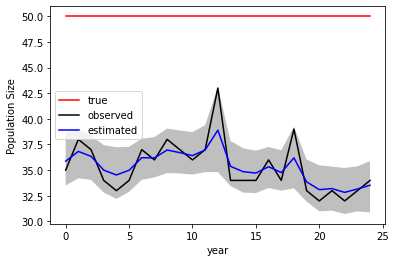

In [202]:
fitted, lower, upper = np.zeros(25), np.zeros(25), np.zeros(25)
for i  in range(0, n_years):
    fitted[i] = np.mean(model_53_samples['N.est'][i])
    lower[i] = np.quantile(model_53_samples['N.est'][i], 0.025)
    upper[i] = np.quantile(model_53_samples['N.est'][i], 0.975)

plt.plot(range(0, 25), N, color='red', label='true')
plt.plot(range(0, 25), y, color='black', label='observed')
plt.plot(range(0, 25), fitted, color='blue', label='estimated')
plt.ylabel('Population Size')
plt.xlabel('year')
plt.fill_between(range(0, 25), lower, upper, facecolor='grey', alpha=.5)
plt.legend()

## Simulate counts using binomial distr.

In [203]:
n_years = 25
N = np.repeat(50, n_years)

lp = [-0.5 + 0.1 * x for x in range(0, n_years)]
p = scipy.stats.norm.cdf(lp)

y = np.zeros(25)

for t in range(0, n_years):
     y[t] = np.random.binomial(N[t], p[t], 1)


In [204]:
jags_data = {
    "y": y,
    "T": n_years
}

In [207]:
model_54 = pyjags.Model(
    code = model_52,
    data = jags_data,
    chains = n_chains, 
    init = inits
)



adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


In [208]:
model_54.sample(burnin, vars=[], thin=thinning)

sampling: iterations 30000 of 30000, elapsed 0:00:03, remaining 0:00:00


{}

In [209]:
model_54_samples = model_54.sample(n_iterations, vars=parameters)

sampling: iterations 41616 of 75000, elapsed 0:00:05, remaining 0:00:04
sampling: iterations 75000 of 75000, elapsed 0:00:09, remaining 0:00:00


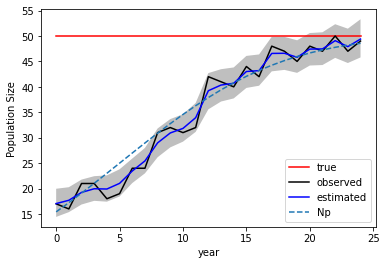

In [210]:
fitted, lower, upper = np.zeros(25), np.zeros(25), np.zeros(25)
for i in range(0, n_years):
    fitted[i] = np.mean(model_54_samples['N.est'][i])
    lower[i] = np.quantile(model_54_samples['N.est'][i], 0.025)
    upper[i] = np.quantile(model_54_samples['N.est'][i], 0.975)

plt.plot(range(0, 25), N, color='red', label='true')
plt.plot(range(0, 25), y, color='black', label='observed')
plt.plot(range(0, 25), fitted, color='blue', label='estimated')
plt.plot(N*p, label='Np', linestyle='dashed')
plt.ylabel('Population Size')
plt.xlabel('year')
plt.fill_between(range(0, 25), lower, upper, facecolor='grey', alpha=.5)
plt.legend()

# 5.4. Real example

In [328]:
model_54 = '''
model {
# Priors and constraints
logN.est[1] ~ dnorm(5.6, 0.01)       # Prior for initial population size
mean.r ~ dnorm(1, 0.001)             # Prior for mean growth rate
sigma.proc ~ dunif(0, 1)             # Prior for sd of state process
sigma2.proc <- pow(sigma.proc, 2)
tau.proc <- pow(sigma.proc, -2)
sigma.obs ~ dunif(0, 1)              # Prior for sd of observation process
sigma2.obs <- pow(sigma.obs, 2)
tau.obs <- pow(sigma.obs, -2)

# Likelihood
# State process
for (t in 1:(T-1)){
   r[t] ~ dnorm(mean.r, tau.proc)
   logN.est[t+1] <- logN.est[t] + r[t]
   }
   
# Observation process
for (t in 1:T) {
   y[t] ~ dnorm(logN.est[t], tau.obs)
   }

# Population sizes on real scale
for (t in 1:T) {
   N.est[t] <- exp(logN.est[t])
   }
}
'''

In [329]:
# House martin population data from Magden
p_years = 6 # Number of future years with predictions
B = np.zeros(p_years)
B[:] = 0

A = np.array([271, 261, 309, 318, 231, 216, 208, 226, 195, 226, 233, 209, 226, 192, 191, 225, 245, 205, 191, 174, 174, 174, 174, 174, 174])

## repeated missing values, this is incorrect. fix. 
hm = np.concatenate([A])
years = range(1990, 2009+p_years)

In [330]:
jags_data = {
    "y": np.log(hm),
    "T": len(years)
}

In [331]:
len(jags_data['y'])

25

In [332]:
inits = {}

A = np.zeros(len(years))
A[:] = JAGS_NA
A[0] = np.random.normal(5.6, 0.1, 1)

inits['logN.est'] = A
inits['sigma.proc'] = np.random.uniform(0, 1, 1)
inits['mean.r'] = np.random.normal(1)
inits['sigma.obs'] = np.random.uniform(0, 1, 1)

In [333]:
parameters = ['r', 'mean.r', 'sigma2.obs', 'sigma2.proc', 'N.est']

In [334]:
n_iterations = 200000 # number of iterations
thinning = 6 # thinning
burnin = 100000 #burn-in
n_chains = 3

In [335]:
model_54_jags = pyjags.Model(
    code = model_54,
    data = jags_data,
    chains = n_chains,
    init = inits
)


adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


In [336]:
model_54_jags.sample(burnin, vars=[], thin=thinning)


sampling: iterations 126069 of 300000, elapsed 0:00:05, remaining 0:00:07
sampling: iterations 246816 of 300000, elapsed 0:00:10, remaining 0:00:02
sampling: iterations 300000 of 300000, elapsed 0:00:12, remaining 0:00:00


{}

In [337]:

jags_samples = model_54_jags.sample(n_iterations, vars=parameters)

sampling: iterations 124824 of 600000, elapsed 0:00:05, remaining 0:00:20
sampling: iterations 245277 of 600000, elapsed 0:00:10, remaining 0:00:15
sampling: iterations 364914 of 600000, elapsed 0:00:16, remaining 0:00:10
sampling: iterations 595437 of 600000, elapsed 0:00:26, remaining 0:00:00
sampling: iterations 600000 of 600000, elapsed 0:00:26, remaining 0:00:00


In [338]:
data_model54 = \
    az.from_pyjags(jags_samples)

az.summary(data_model54)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
N.est[0],273.728,13.463,248.584,301.805,0.104,0.076,18871.0,22113.0,1.0
N.est[1],269.147,12.650,247.791,295.278,0.221,0.157,3634.0,22136.0,1.0
N.est[2],293.211,18.998,254.414,320.840,0.537,0.380,1385.0,7024.0,1.0
N.est[3],292.177,23.316,249.432,324.682,0.812,0.583,847.0,7770.0,1.0
N.est[4],240.774,11.607,222.193,263.977,0.282,0.199,1784.0,22015.0,1.0
N.est[5],224.090,12.438,204.704,249.887,0.275,0.196,2493.0,11978.0,1.0
N.est[6],216.511,12.286,197.979,242.720,0.296,0.210,2045.0,8686.0,1.0
N.est[7],222.463,9.709,202.858,240.737,0.091,0.064,11351.0,15922.0,1.0
N.est[8],207.276,12.861,189.010,232.982,0.384,0.272,1147.0,9263.0,1.0
N.est[9],222.509,9.046,203.926,239.175,0.085,0.060,11923.0,26279.0,1.0


In [341]:
jags_samples['N.est']

array([[[265.29471974, 262.37812231, 229.10478228],
        [271.5454082 , 270.81896514, 253.84029658],
        [267.17919866, 274.39608547, 252.00276491],
        ...,
        [271.54399108, 272.72661853, 266.72370952],
        [280.82564945, 273.23132997, 263.5572815 ],
        [288.57027789, 272.91347796, 265.46693839]],

       [[273.41351654, 267.1179505 , 226.56608438],
        [277.42121223, 268.76030358, 251.56438048],
        [273.46178958, 265.25549896, 249.24516969],
        ...,
        [273.83995785, 266.27982735, 255.8461952 ],
        [271.66306715, 266.82437095, 265.54853473],
        [281.54082039, 266.57866652, 261.52396843]],

       [[315.63824959, 277.44238603, 224.11420639],
        [319.26908264, 274.85940728, 248.75784914],
        [317.15931407, 280.05216108, 245.84839895],
        ...,
        [267.62511412, 314.69827033, 278.37011251],
        [267.85875098, 313.79991337, 284.41235167],
        [274.07415273, 314.32185698, 284.82828816]],

       ...,

      

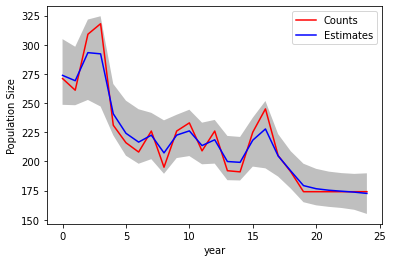

In [354]:
fitted, lower, upper = np.zeros(25), np.zeros(25), np.zeros(25)


for i in range(0, 25):
    fitted[i] = np.mean(jags_samples['N.est'][i])
    lower[i] = np.quantile(jags_samples['N.est'][i], 0.025)
    upper[i] = np.quantile(jags_samples['N.est'][i], 0.975)

plt.plot(range(0, 25), hm, color='red', label='Counts')

plt.plot(range(0, 25), fitted, color='blue', label='Estimates')
plt.ylabel('Population Size')
plt.xlabel('year')
plt.fill_between(range(0, 25), lower, upper, facecolor='grey', alpha=.5)
plt.legend()